## yfactor_necstdb.py 用可視化ツールの template です。
- 概要：
  - 全 cell を実行すると、20 IF の hot / cold の oneshot と y-factor が表示されます
- 特筆事項：
  - 20 IF 分のデータが存在しなくても、存在する XFFTS データのみで plot 可能です
-  <font color="red">notebook 上で plot を行いたい場合：　</font>
  - 「モジュールを import します。」 の cell で%matplotlib inline のコメントアウトを外してください

### モジュールを import します。

In [3]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
# %matplotlib inline
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import necstdb

### database を読み込みます。

In [4]:
cwd = os.getcwd()
mode, date = cwd.split('/')[-2], cwd.split('/')[-1]

date = '20190908_115337'

data_path_hot = '/home/amigos/data/rx/{mode}/hot/{date}.necstdb/'.format(**locals())
data_path_cold = '/home/amigos/data/rx/{mode}/cold/{date}.necstdb/'.format(**locals())

# data_path = [
#     '/mnt/media/usbdisk/data/rx/{mode}/hot/{date}'.format(**locals()),
#     '/mnt/media/usbdisk/data/rx/{mode}/cold/{date}'.format(**locals())
# ]

db_hot = necstdb.opendb(data_path_hot)
db_cold = necstdb.opendb(data_path_cold)

### hot, cold, y-factor, Trx を計算します。

In [14]:
ch_num = 20
d_hot, d_cold = {}, {}
for ch in range(1, ch_num + 1):
    t0 = time.time()
    board_name = 'xffts_board{}'.format(str(ch).zfill(2))
    try:
        d_hot[board_name] = np.array(db_hot.open_table(board_name).read())
        d_cold[board_name] = np.array(db_cold.open_table(board_name).read())
        print('info : {} db is loaded. ( time : {:.2f} sec. )'.format(board_name, time.time() - t0))
    except:
        d_hot[board_name] = np.zeros((2, 2 ** 15 + 1)) # shape = (2, 32769)
        d_cold[board_name] = np.zeros((2, 2 ** 15 + 1))
        t1 = time.time()
        print('alart : {} db is not exist. ( time : {:.2f} sec. )'.format(board_name, time.time() - t0))

info : xffts_board01 db is loaded. ( time : 0.33 sec. )
info : xffts_board02 db is loaded. ( time : 0.32 sec. )
info : xffts_board03 db is loaded. ( time : 0.32 sec. )
info : xffts_board04 db is loaded. ( time : 0.33 sec. )
info : xffts_board05 db is loaded. ( time : 0.32 sec. )
info : xffts_board06 db is loaded. ( time : 0.32 sec. )
info : xffts_board07 db is loaded. ( time : 0.32 sec. )
info : xffts_board08 db is loaded. ( time : 0.32 sec. )
info : xffts_board09 db is loaded. ( time : 0.33 sec. )
info : xffts_board10 db is loaded. ( time : 0.32 sec. )
info : xffts_board11 db is loaded. ( time : 0.34 sec. )
info : xffts_board12 db is loaded. ( time : 0.32 sec. )
info : xffts_board13 db is loaded. ( time : 0.32 sec. )
info : xffts_board14 db is loaded. ( time : 0.32 sec. )
info : xffts_board15 db is loaded. ( time : 0.33 sec. )
info : xffts_board16 db is loaded. ( time : 0.32 sec. )
info : xffts_board17 db is loaded. ( time : 0.34 sec. )
info : xffts_board18 db is loaded. ( time : 0.34

In [5]:
hot, cold = {}, {}
try:
    for key, val_hot, val_cold in zip(d_hot.keys(), d_hot.values(), d_cold.values()):
        hot[key]= np.delete(np.average(val_hot, axis=0), 0)
        cold[key]= np.delete(np.average(val_cold, axis=0), 0)
except: pass        
# memory freeing    
del(d_hot)
del(d_cold)

In [6]:
freq = np.linspace(0, 2000, 2**15) / 1e3
Thot, Tcold = 300., 77.
yfac, Trx = {}, {}
for key, val_hot, val_cold in zip(hot.keys(), hot.values(), cold.values()):
    yfac[key] = val_hot / val_cold 
    Trx[key] = (Thot - Tcold) * (val_hot / val_cold) / ((val_hot / val_cold) - 1)

### hot, cold を plot します。

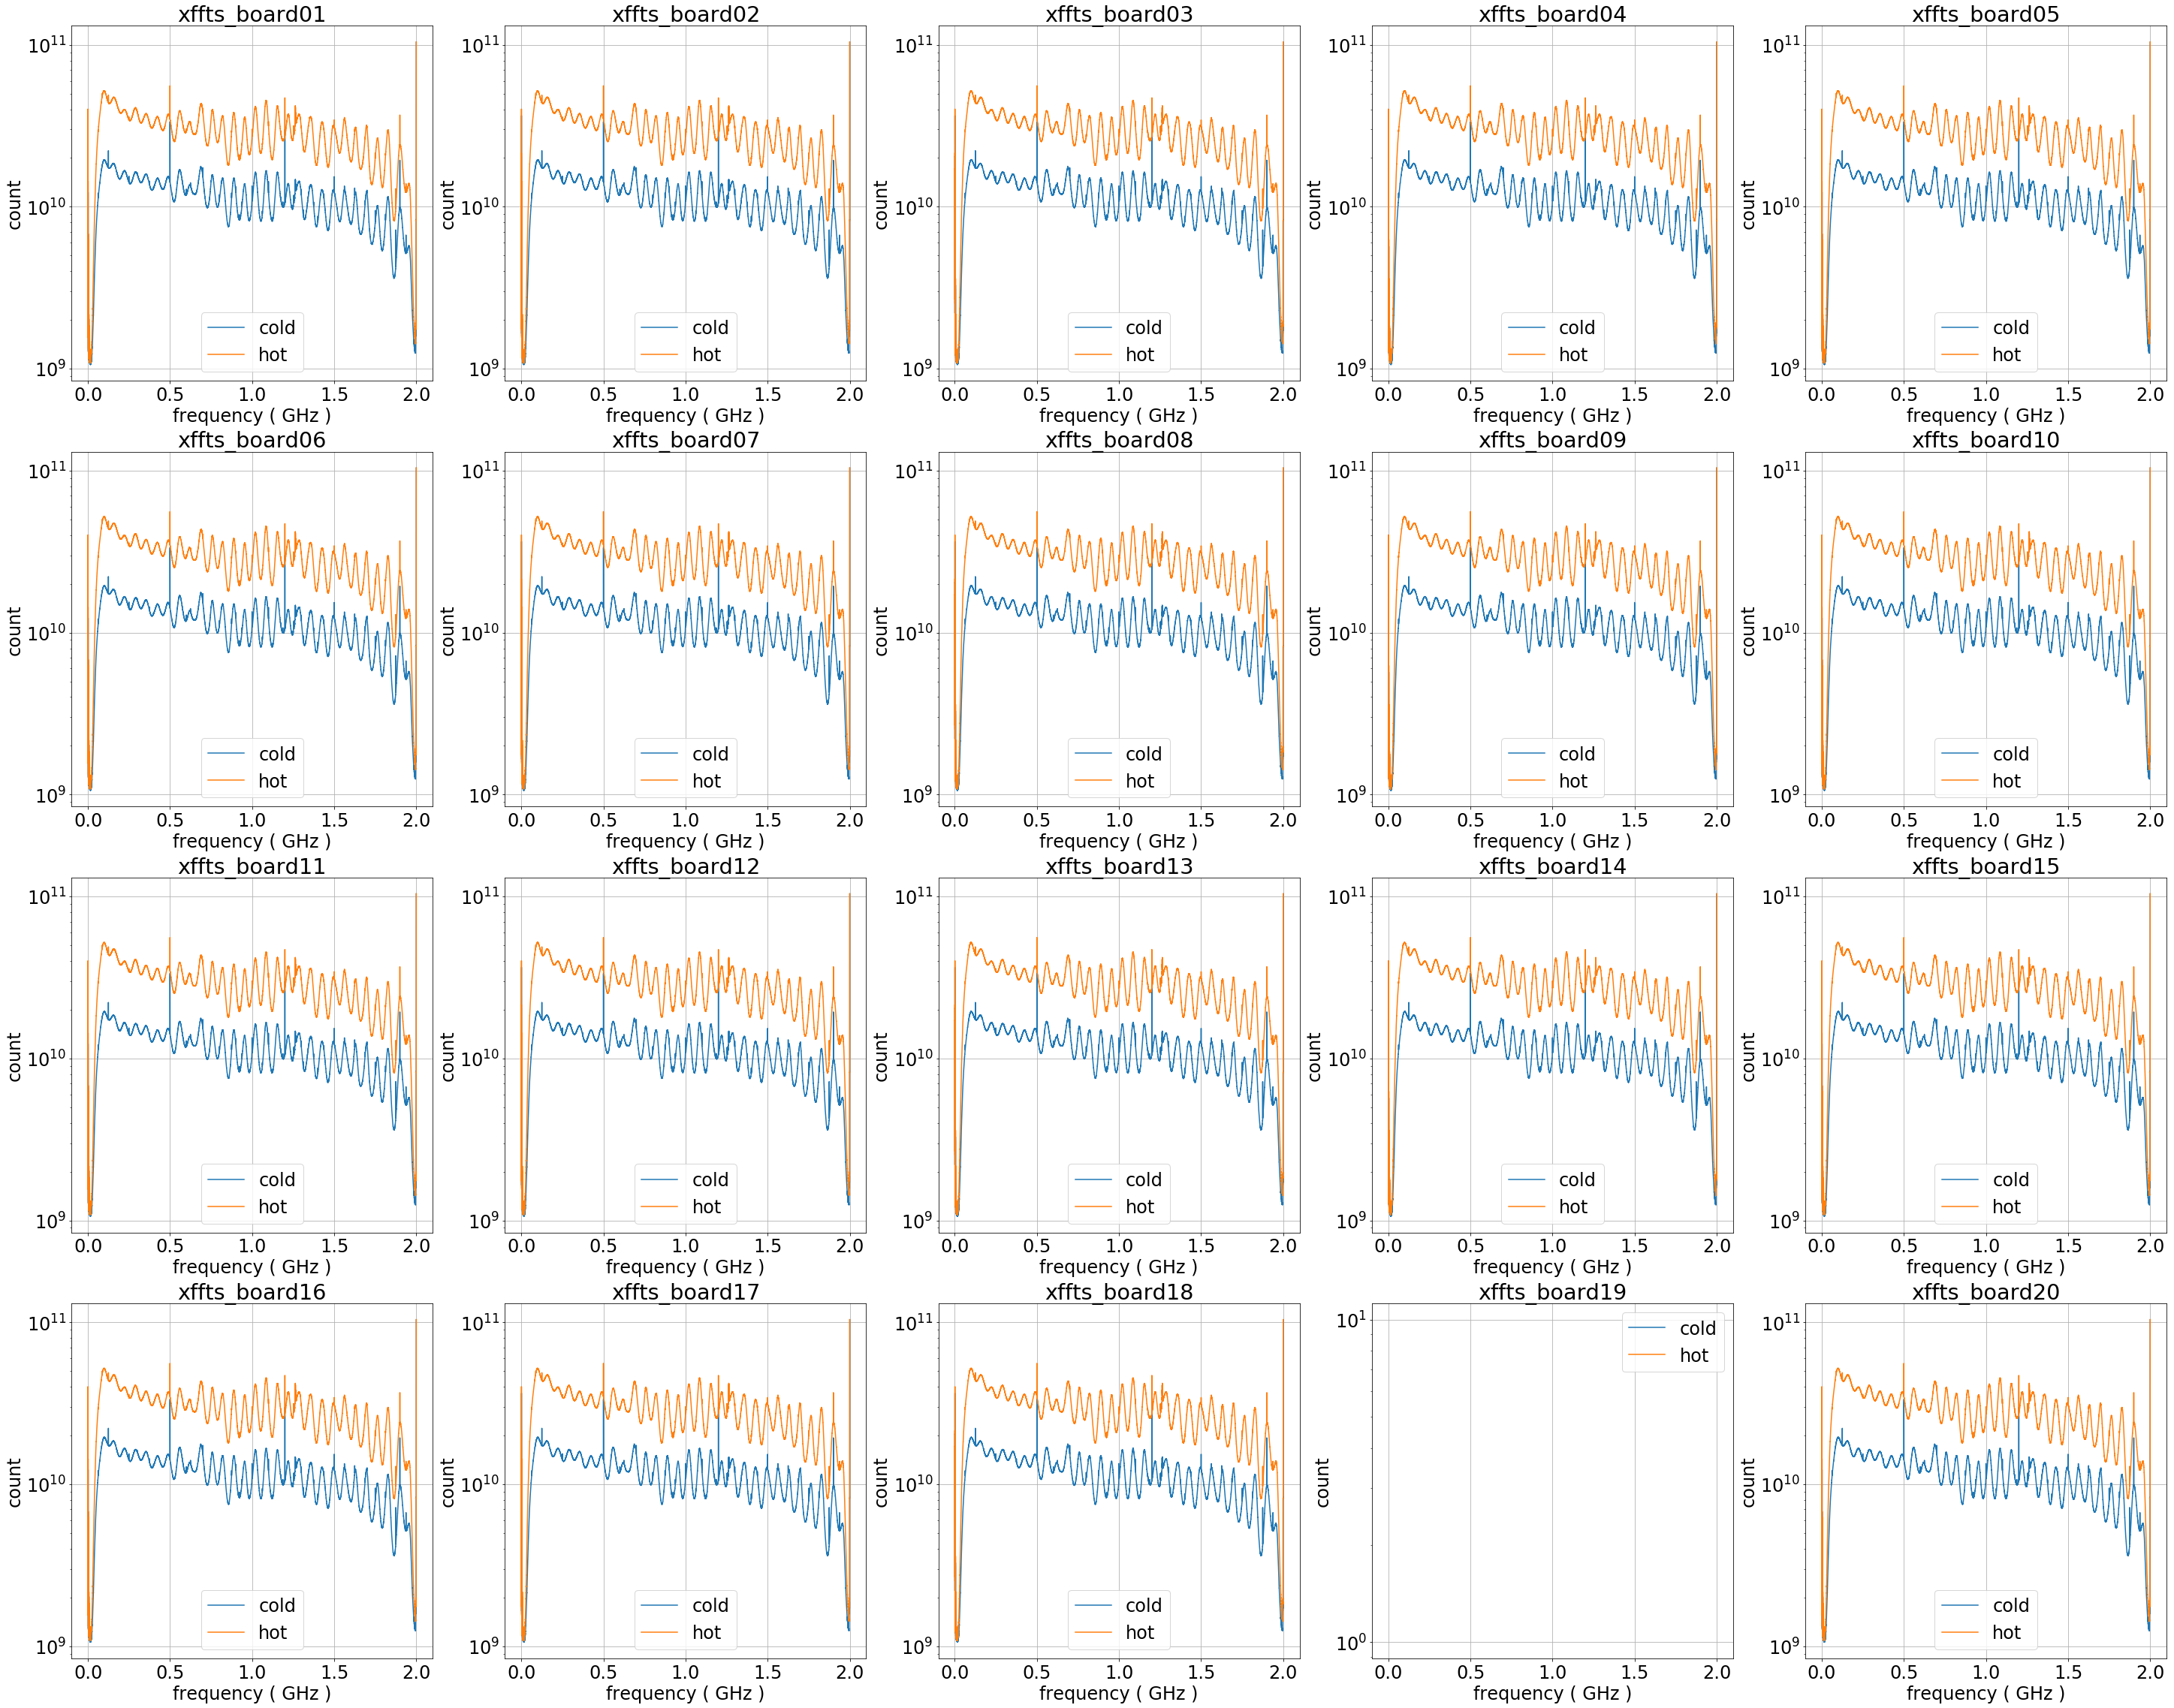

In [7]:
ncol = 5
nrow = 4
nax = ncol * nrow

figsize = (ncol * 3, nrow * 3)

fig = matplotlib.pyplot.figure(figsize=figsize)
ax = [fig.add_subplot(nrow, ncol, i+1) for i in range(nax)]

for _ax, board, _hot, _cold in zip(ax, hot.keys(), hot.values(), cold.values()):
    _ax.plot(freq, _cold, label='cold')
    _ax.plot(freq, _hot, label='hot')
    _ax.set_xlabel('frequency ( GHz )')
    _ax.set_yscale('log')
    _ax.set_ylabel('count')
    _ax.set_title(board)
    _ax.grid()
    _ax.legend()
    
plt.suptitle('{date} : {mode}'.format(**locals()), fontsize=18)
plt.subplots_adjust(wspace=0.25, hspace=0.25, bottom=0.05)
plt.tight_layout()
plt.subplots_adjust(top=0.935)

plt.savefig('./hot_cold.png')
print('info : Saved image. ( hot_cold.png )')

### y-factor を plot します。

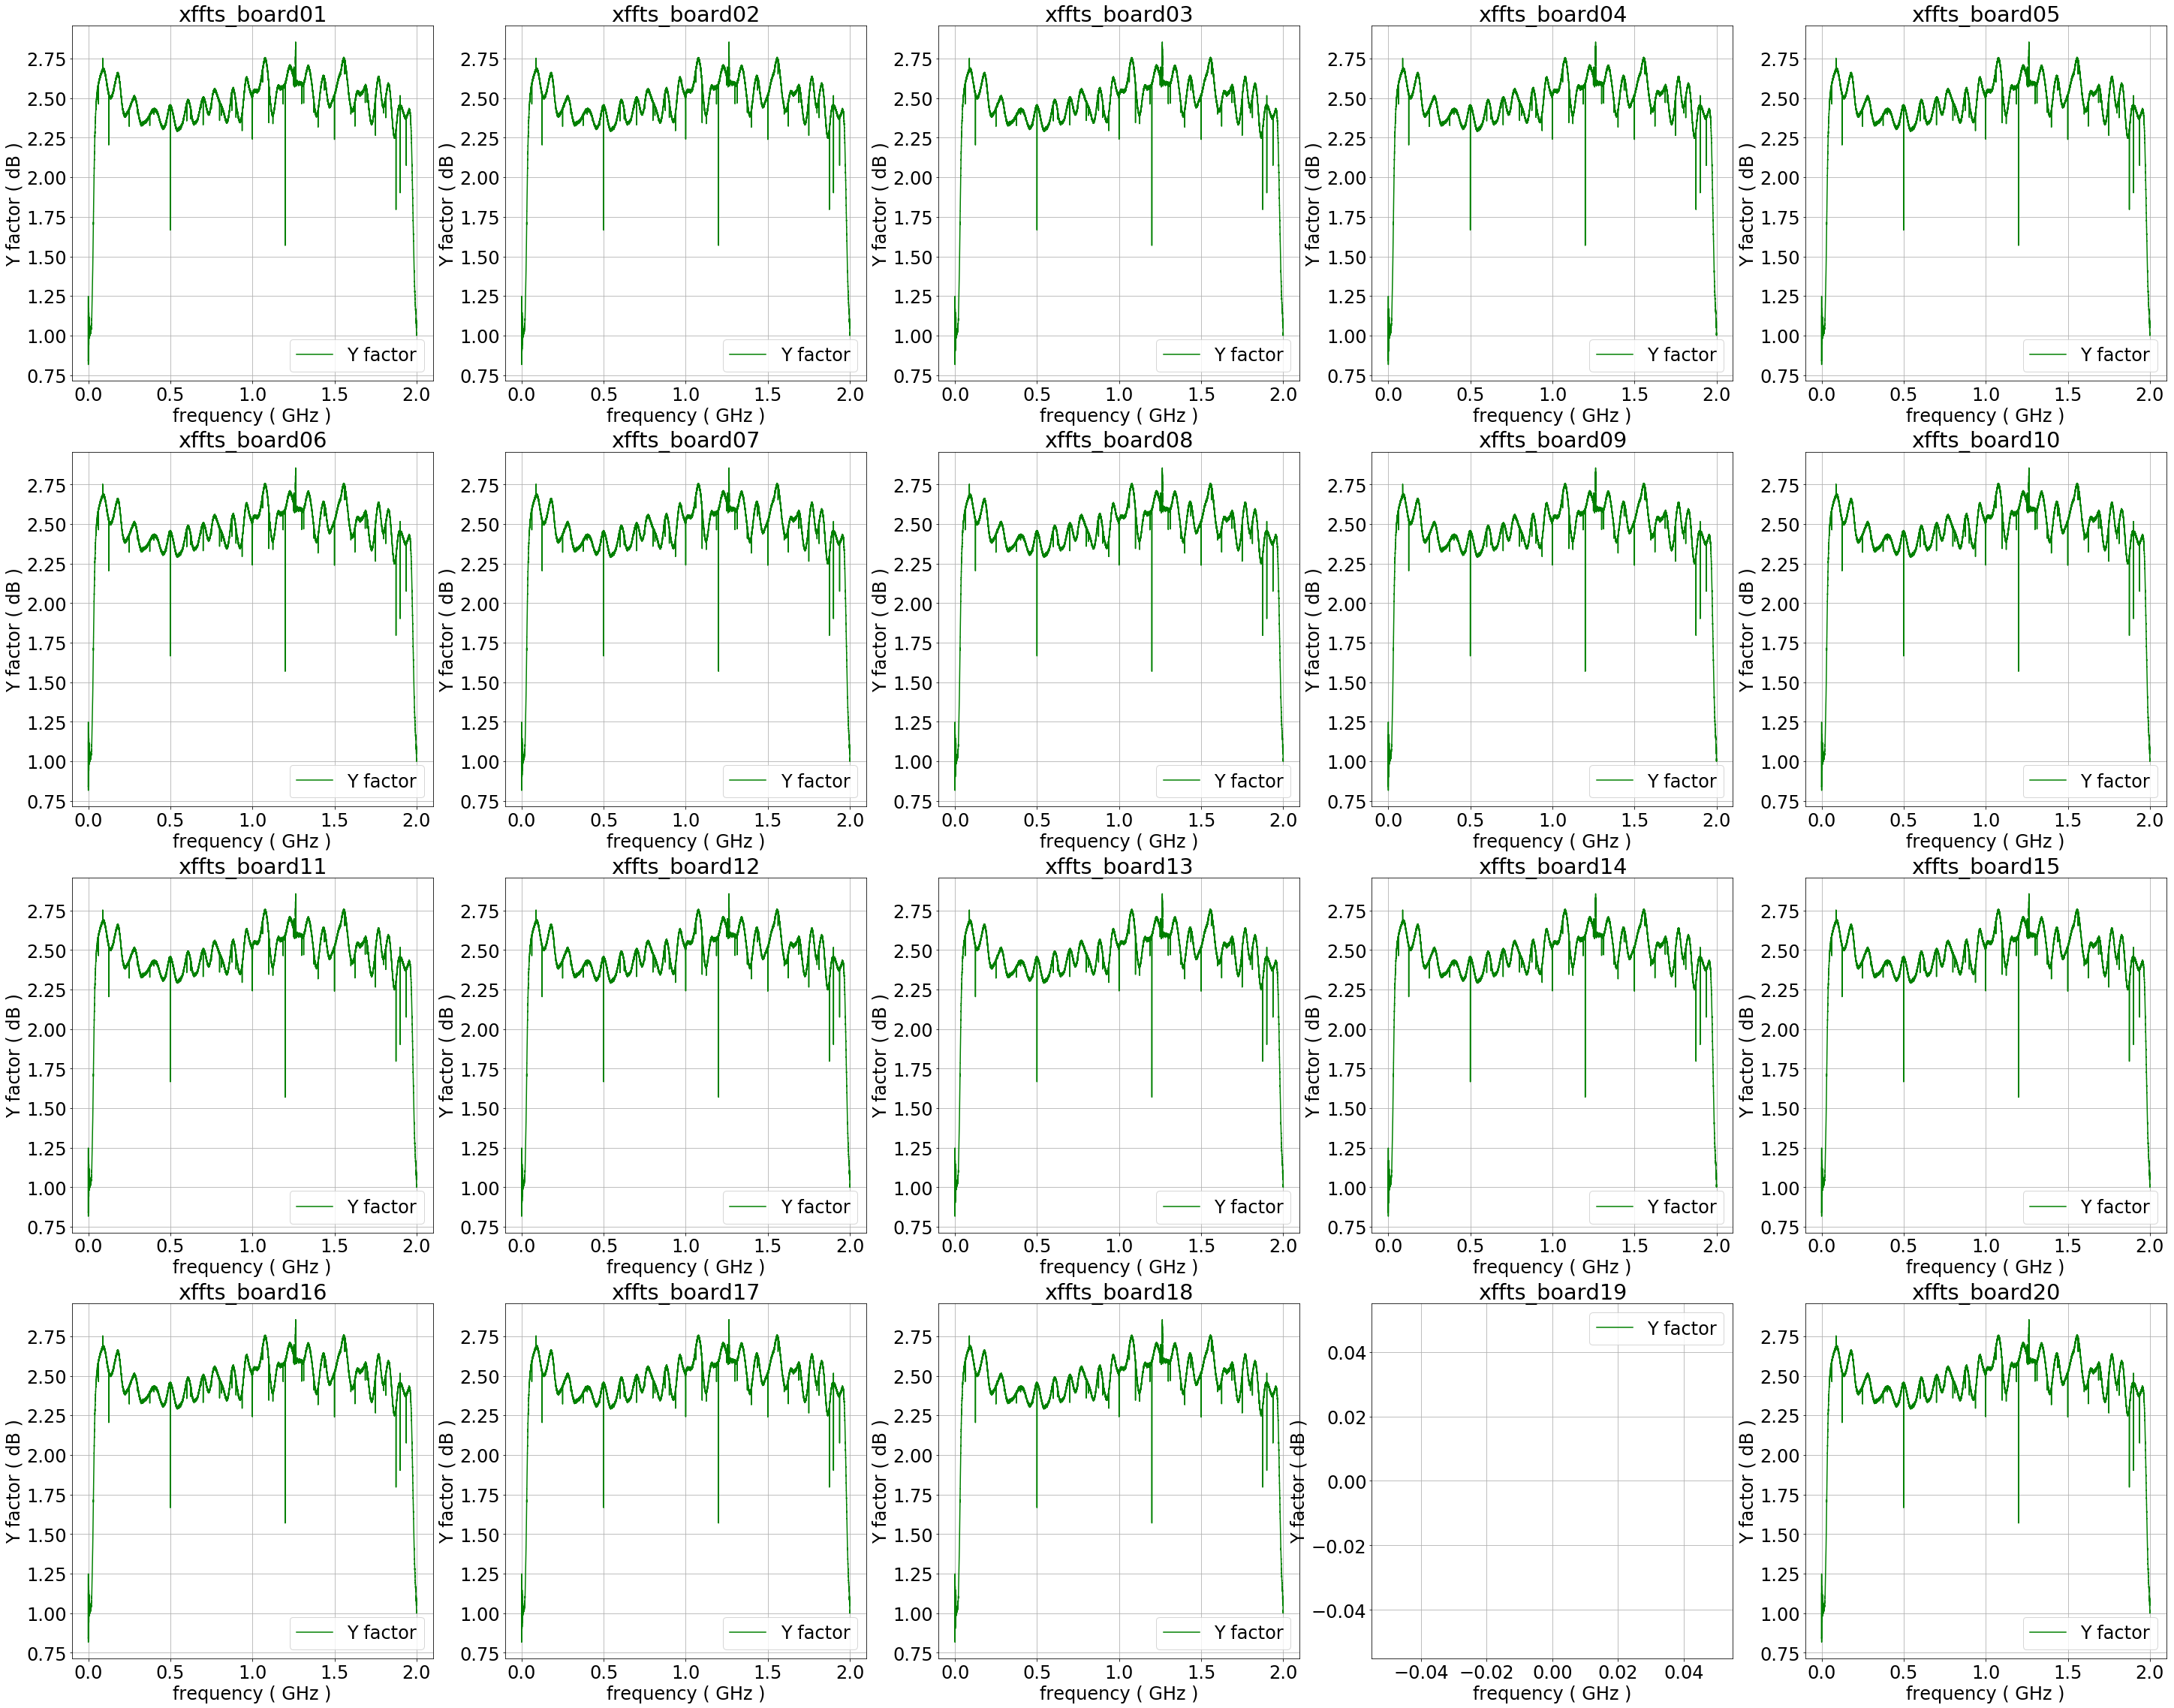

In [8]:
fig = matplotlib.pyplot.figure(figsize=figsize)
ax = [fig.add_subplot(nrow, ncol, i+1) for i in range(nax)]

for _ax, board, _yfac in zip(ax, yfac.keys(), yfac.values()):
    _ax.plot(freq, _yfac, label='Y factor', c='green')
    _ax.set_xlabel('frequency ( GHz )')
    _ax.set_ylabel('Y factor ( dB )')
    _ax.set_title(board)
    _ax.grid()
    _ax.legend()
    
plt.suptitle('{date} : {mode}'.format(**locals()), fontsize=18)
plt.subplots_adjust(wspace=0.25, hspace=0.25, bottom=0.05)
plt.tight_layout()
plt.subplots_adjust(top=0.935)

plt.savefig('./yfactor.png')
print('info : Saved image. ( yfactor.png )')